In [1]:
# Matrix Manipulation
import numpy as np
import pandas as pd

# Utility operations
from numpy import log as ln
import math
import random

# Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Saving objects
import pickle

# Optimization
from functools import partial
from itertools import chain

# Utility Functions

In [2]:
class HDCModels():
    @classmethod
    def save_model(self, model, filename):
        with open(filename, 'wb') as outp:
            pickle.dump(model, outp, pickle.HIGHEST_PROTOCOL)
    
    @classmethod
    def load_model(self, filename):
        with open(filename, 'rb') as inp:
            return pickle.load(inp)

class ItemMemories():
    @classmethod
    def save_IM(self, im, filename):
        with open(filename, 'wb') as outp:
            pickle.dump(im, outp, pickle.HIGHEST_PROTOCOL)
    
    @classmethod
    def load_IM(self, filename):
        with open(filename, 'rb') as inp:
            return pickle.load(inp)
        
class Data():
    @classmethod
    def save(self, data, filename):
        with open(filename, 'wb') as outp:
            pickle.dump(data, outp, pickle.HIGHEST_PROTOCOL)
    
    @classmethod
    def load(self, filename):
        with open(filename, 'rb') as inp:
            return pickle.load(inp)

class SparseHDC():
    # Cyclic shifts the input hypervector arr by shift_count
    @classmethod
    def cyclic_shift(self, arr, shift_count=1):
        return np.concatenate((arr[-shift_count:],arr[:-shift_count]))
    
    @classmethod
    def dot(self, hv1, hv2):
        return np.sum(np.logical_and(hv1, hv2))
    
    @classmethod
    def disp(self, hv):
        s = math.sqrt(len(hv))
        if (s-int(s)):
            return "Must be square"
        
        return np.array(hv).reshape(int(s),int(s))

    # Generate a random sparse HV with dimension and sparsity
    @classmethod
    def generate_random_sparse_HV(self, dim = 10000, sparsity=0.3):
        percent_sparsity = int(100*sparsity)
        return np.vectorize(SparseHDC._generation_threshold)(np.random.randint(101,size=dim), percent_sparsity)
    
    # Generate count number of sparse HVs with dimension and sparsity
    @classmethod
    def generate_random_sparse_HVs(self, count=10, dim = 10000, sparsity=0.3):
        return [SparseHDC.generate_random_sparse_HV(dim, sparsity) for i in range(0,count)]
    
    # Generate a sparse HV with exact sparsity
    @classmethod
    def generate_sparse_HV(self, dim=10000, sparsity=0.3):
        hv = np.repeat(0,dim)
        hv[random.sample(range(0,dim),int(sparsity*dim))]=1
        return hv
    
    # Generate count number of sparse HV with dimension and exact sparsity
    @classmethod
    def generate_sparse_HVs(self, count=10, dim=10000, sparsity=0.3):
        return [SparseHDC.generate_sparse_HV(dim, sparsity) for i in range(0,count)]
    
    # Generate maximally sparse HV with exact dimension and sparsity
    @classmethod
    def generate_max_sparse_HV(self, dim=10000, sparsity=0.3):
        hv = np.repeat(0,dim)
        step = int(1/sparsity)
        hv[[random.sample(range(n*step, (n+1)*step),1)[0] for n in range(0,int(dim/step))]]=1
        return hv
    
    # PRIVATE METHODS
    
    # Returns 1 if num < percent_sparsity where 0<=num<=100
    @classmethod
    def _generation_threshold(self, num, percent_sparsity = 30):
        return 1 if num<percent_sparsity else 0

# Datasets

In [3]:
class ISOLET():
    def __init__ (self, train_filepath = 'isolet1+2+3+4.csv', test_filepath = 'isolet5.csv'):
        self.train = pd.read_csv(train_filepath, header=None)
        self.train_X = self.train[[i for i in range(0,617)]]
        self.train_y = self.train[617]
        self.test = pd.read_csv(test_filepath, header=None)
        self.test_X = self.test[[i for i in range(0,617)]]
        self.test_y = self.test[617]
        
class ItemMemory():
    def __init__(self, cim, base_hvs):
        self.cim = cim
        self.base_hvs = base_hvs

# CIM

In [4]:
class LinearCIM():
    def __init__(self, sparsity=0.3, dim=10000, seed=None):
        self.sparsity = sparsity
        self.dim = dim
        self.seed = seed
    
    def modify_specs(self, sparsity=None, dim=None):
        self.sparsity = sparsity if sparsity else self.sparsity
        self.dim = dim if dim else self.dim

    def generate(self, keys, max_sparse=False):
        if self.seed is None:
            if max_sparse:
                seed = SparseHDC.generate_max_sparse_HV(sparsity=self.sparsity, dim=self.dim)
            else:
                seed = SparseHDC.generate_sparse_HV(sparsity=self.sparsity, dim=self.dim)
        else:
            seed = self.seed
        
        hvs = [seed]
        bit_step = int(np.sum(seed)/(len(keys)-1))
        
        if max_sparse:
            ranges= set(range(0,np.sum(seed)))
            range_length = int(1/self.sparsity)
            
            # Iterate over the seoncds key up
            for i in range(1, len(keys)):
                next_hv = np.copy(hvs[i-1])
                
                # Get random bit_step # of bit ranges
                range_nos = set(random.sample(ranges, k=bit_step))
                
                # Remove these bit ranges in the tracker
                
                # For each range
                for no in range_nos:
                    l = no*range_length
                    u = (no+1)*range_length
                    loc = l + list(next_hv[l:u]).index(1)
                    mov = random.sample(set(range(l,u))-{loc}, k=1)
                    next_hv[loc] = 0
                    next_hv[mov] = 1
                
                ranges -= range_nos
                
                hvs.append(next_hv)
            
        else:
            tracker = pd.Series(np.copy(seed))

            for i in range(1,len(keys)):
                next_hv = np.copy(hvs[i-1])

                # TURN OFF K bits
                turnoff_index = random.sample(list(tracker[tracker==1].index), bit_step)
                tracker[turnoff_index]=-1 #Update to cannot be touched
                next_hv[turnoff_index]=0 #Turn them off from previous hv

                # TURN ON K bits
                turnon_index = random.sample(list(tracker[tracker==0].index), bit_step)
                tracker[turnon_index]=-1 #Update to cannot be touched
                next_hv[turnon_index]=1 #Turn them on

                hvs.append(next_hv)

        return dict(zip(keys,hvs))

# Sparsifiers

In [5]:
# Sparsifying Method

class ThresholdingSparsifier():
    def __init__(self, percent_max_val=0.3, max_val=617):
        self.percent_max_val = percent_max_val
        self.max_val = max_val
    
    def sparsify(self, hv):
        return np.array((hv>self.threshold())).astype(np.int)
    
    def threshold(self):
        return int(self.percent_max_val*self.max_val)

# Encoding Algorithms

In [6]:
class HoloGNEncoder():
    def __init__(self, M, cim, sparsifier, feature_count=617, shifts=None):
        self.M = M
        self.qlevels = self.quantization_levels(M)
        self.cim = cim.generate(self.qlevels)
        self.sparsifier = sparsifier
        self.shifts = random.sample(range(0,feature_count),feature_count) if shifts is None else shifts
        
    def encode(self, features, return_accumulated=False):
        # Quantize
        quantized =  (map(self.get_level_hv, features))
        # Get the shifted versions
        shifted = pd.Series(map(SparseHDC.cyclic_shift, quantized, self.shifts))
        # Sum up the shifted versions
        acc = np.sum(shifted)
        # Sparsify
        sparse = self.sparsifier.sparsify(acc)
        return acc if return_accumulated else sparse
        

    def quantization_levels(self, M, min_val=-1, max_val=1, precision=5):
        step = (max_val - min_val) / (M-1)
        qlevels = list(np.arange(min_val, max_val+(0.1*step), step).round(precision))
        return qlevels

    def get_level_hv(self, value, index=False):
        closest_value = min(self.qlevels, key=lambda x:abs(x-value))
        return self.cim[closest_value]

In [7]:
# END-TO-END

class HDC_Classifier():
    def __init__(self, encoder, ACC_THR = 125, training_data=ISOLET()):
        self.encoder = encoder
        self.data = training_data
        self.class_hvs = {}
        self.training_encoded = {}
        self.test_encoded = None
        self.ACC_THR = ACC_THR

    def train(self, save_encodes=True):      
        # Group rows by class
        classes = self.train_y().unique()
        class_rows = {}
        class_hvs = {}
        
    # Segregate the rows into their corresponding classes
        # Get the indexes of the rows of different classes
        class_indexes = {}
        for class_ in classes:
            class_indexes[class_] = list(self.train_y()[self.train_y()==class_].index)

        # Segregated the rows
        for class_ in classes:
            class_rows[class_] = np.array(list(self.train_X().loc[class_indexes[class_]].itertuples(index=False, name=None)))

        encoded = {}
        for class_ in classes:
            print("Encoding... {}% ".format(round(100*class_/classes[-1],2)))
            encoded[class_] = pd.Series(map(self.encoder.encode, class_rows[class_]))
        if save_encodes:
            self.training_encoded = encoded
        
        accumulated = np.array([np.sum(encoded[class_]) for class_ in classes])
        class_sparsifier = ThresholdingSparsifier(percent_max_val = self.ACC_THR/240, max_val=240)
        thresholded = pd.Series(map(class_sparsifier.sparsify, accumulated))
        thresholded.index = range(1,27)
        
        self.class_hvs = dict(thresholded)
        
        return "Done"
    
    def test(self):
        encoded_test = pd.Series(map(self.encoder.encode, np.array(self.test_X())))
        predictions = pd.Series(map(self.query, encoded_test))
        return np.sum(predictions == self.test_y())/len(self.test_y())

    # HELPER FUNCTIONS
    def query(self, query_hv):
        d = dict([[class_, SparseHDC.dot(class_hv, query_hv)] for class_,class_hv in self.class_hvs.items()])
        return max(d, key=d.get)
    
    def train_X(self):
        return self.data.train_X
    
    def train_y(self):
        return self.data.train_y
    
    def test_X(self):
        return self.data.test_X
    
    def test_y(self):
        return self.data.test_y

# MODEL DEVELOPMENT

### CONVERT NEXT THREE CELLS TO CODE AND RUN AS NEEDED

In [8]:
# RUN THIS ONCE

isolet = ISOLET()

# Rows in each class
class_indexes = {}
classes = range(1,27)
for class_ in classes:
    class_indexes[class_] = list(isolet.train_y[isolet.train_y==class_].index)

# Rows for each class
# class_rows[class_no][sample_no], class_no corresponds to A-Z but 1-26 instead
class_rows = {}
for class_ in classes:
    class_rows[class_] = np.array(list(isolet.train_X.loc[class_indexes[class_]].itertuples(index=False, name=None)))
    
# 10 rows for each class
test_class_rows = {}

for class_, rows in class_rows.items():
    test_class_rows[class_] = rows[0:10]

In [9]:
def plot_sparsity_vs_accumulation_threshold(encoded_training_data, sparsity, interval=[0,99]):
    classes = list(encoded_training_data.keys())
    dim = len(encoded_training_data[classes[0]][0])
    
    #Accumulate each class
    class_accumulations = [np.sum(encoded_training_data[class_]) for class_ in classes]
    
    for accumulation in class_accumulations:
        sparsities = []
        for i in range(interval[0],interval[1]+1):
            sp = ThresholdingSparsifier(percent_max_val=i/100, max_val=240)
            sparsities.append(np.sum(sp.sparsify(accumulation))/dim)
        plt.plot(range(interval[0],interval[1]+1), sparsities)
        
    plt.title("Sparsity vs Percent ACC THR (Component Sparsity ~{})".format(sparsity))
    plt.xlabel("threshold (% of component count)")
    plt.ylabel("sparsity")
    
def plot_encoding_sparsity_jitter(encoded_training_data, target_sparsity, ENC_THR="x"):
    classes = list(encoded_training_data.keys())
    dim = len(encoded_training_data[classes[0]][0])
    no_of_ones = np.array([])

    for class_ in classes:
        no_of_ones = np.append(no_of_ones, np.vectorize(np.sum)(encoded_training_data[class_]))
        
    sparsities = no_of_ones
    print("Mean sparsity: {}".format(np.average(sparsities)))
    sns.boxplot(sparsities)
    plt.title("Sparsity of Encoded Training Samples at ENC_THR={}".format(ENC_THR))
    plt.xlabel('sample no.')
    plt.ylabel('sparsity')

# TESTING

In [99]:
dim=5000
sp=0.02
ENC_THR=14
ACC_THR=40
M=10

hologn = HoloGNEncoder(M, LinearCIM(dim=dim, sparsity=sp),
                        ThresholdingSparsifier(percent_max_val=ENC_THR/617, max_val=617))

#Override generated CIM from file
hologn.cim = ItemMemories.load_IM('im_5k_sp0.02m10_r0.035_thr15_maxsparse.pkl').cim

#Override encoding shifts with standard shifts
hologn.shifts = Data.load('std_shifts.pkl').shifts

classifier = HDC_Classifier(hologn, ACC_THR=ACC_THR)

In [100]:
classifier.train()

Encoding... 3.85% 
Encoding... 7.69% 
Encoding... 11.54% 
Encoding... 15.38% 
Encoding... 19.23% 
Encoding... 23.08% 
Encoding... 26.92% 
Encoding... 30.77% 
Encoding... 34.62% 
Encoding... 38.46% 
Encoding... 42.31% 
Encoding... 46.15% 
Encoding... 50.0% 
Encoding... 53.85% 
Encoding... 57.69% 
Encoding... 61.54% 
Encoding... 65.38% 
Encoding... 69.23% 
Encoding... 73.08% 
Encoding... 76.92% 
Encoding... 80.77% 
Encoding... 84.62% 
Encoding... 88.46% 
Encoding... 92.31% 
Encoding... 96.15% 
Encoding... 100.0% 


'Done'

In [101]:
classifier.test()

0.8717126363053239

Mean 1478.8846153846155


C:\Users\ACER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

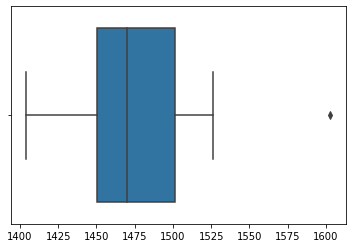

In [103]:
#DETERMINE ACC_THR
acc_thr = ThresholdingSparsifier(percent_max_val=40/240, max_val=240)

no_of_ones = []
for class_ in list(classifier.training_encoded.keys()):
    no_of_ones.append( np.sum(acc_thr.sparsify(np.sum(classifier.training_encoded[class_]))) )

print("Mean {}".format(np.average(no_of_ones)))
sns.boxplot(no_of_ones)

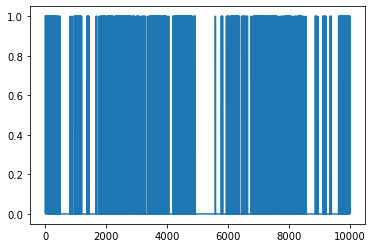

In [306]:
plt.plot(classifier.class_hvs[1])

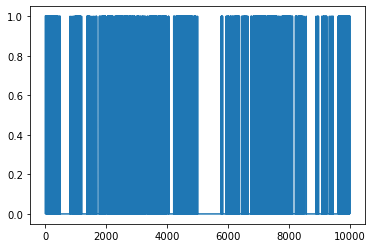

In [307]:
plt.plot(classifier.class_hvs[2])

Mean 1481.2692307692307


C:\Users\ACER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

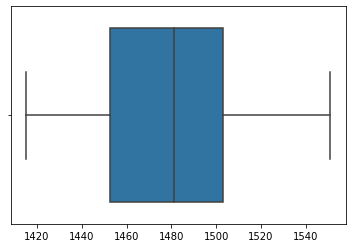

In [308]:
ones = []
for c,hv in classifier.class_hvs.items():
    ones.append(np.sum(hv))
print("Mean {}".format(np.average(ones)))
sns.boxplot(ones)

Mean sparsity: 771.1107726835525


C:\Users\ACER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


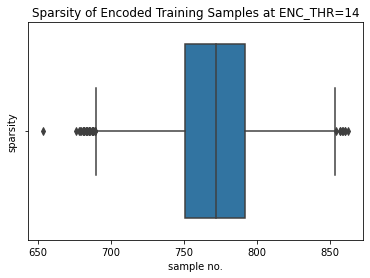

In [104]:
plot_encoding_sparsity_jitter(classifier.training_encoded, target_sparsity=sp, ENC_THR=ENC_THR)

In [310]:
dots = []
class_hvs = list(classifier.class_hvs.values())
for  i in range(0, len(class_hvs)):
    for j in range(i+1, len(class_hvs)):
        if i!=j:
            dots.append(SparseHDC.dot(class_hvs[i], class_hvs[j]))

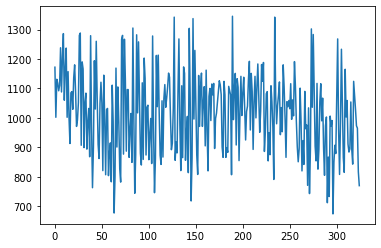

In [311]:
plt.plot(dots)